In [1]:
from cube_loader import load_points_from_stl
from cube_sampler import sample_from_raw_points
from display import plot_3d

raw_data = load_points_from_stl('Blue09.STL')
cube, sample_points = sample_from_raw_points(raw_data)

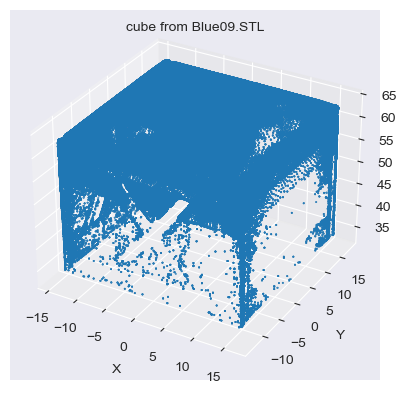

In [2]:
plot_3d(cube, title='cube from Blue09.STL', s=0.1)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA

from rotate import rotate_z

In [4]:
def get_fitted_plane(points, rotate=0, x_adjust=0, y_adjust=0, z_threshold=None):
    # Set the rotation angle in degrees
    theta_degrees = rotate

    # If a threshold is provided, keep only points with a z-coordinate above this threshold
    if z_threshold is not None:
        points = points[points[:, 2] > z_threshold]
        print('cropped')

    # Rotate the points
    points = rotate_z(points, theta_degrees)

    pca = PCA(n_components=3)
    pca.fit(points)

    # The normal of the plane is the smallest principal component
    normal = pca.components_[-1]

    # The point on the plane can be the centroid of the point cloud
    centroid = np.mean(points, axis=0)

    # Now we can print the plane equation
    # The plane equation is of the form ax + by + cz + d = 0
    a, b, c = normal
    d = -centroid.dot(normal)
    print(f"The equation of the plane is {a:.5f}x + {b:.5f}y + {c:.5f}z + {d:.5f} = 0")

    # Get x, y, z coordinates
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    z_coords = points[:, 2]

    # Calculate minimum and maximum values in x and y directions
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)

    x_mid = (x_min + x_max) / 2 + x_adjust
    y_mid = (y_min + y_max) / 2 + y_adjust
    # The range of x and y values for the mesh grid
    x_range = np.linspace(x_mid - 15, x_mid + 15, 42)
    y_range = np.linspace(y_mid - 15, y_mid + 15, 42)

    x, y = np.meshgrid(x_range, y_range)

    # Compute corresponding z values for the plane
    z = (-a * x - b * y - d) / c

    return x, y, z, normal

In [5]:
def get_distances(points, angle=0, a_x=0, a_y=0, a_z=None, nearest_k=3):
    # Construct a k-d tree from the point cloud
    tree = cKDTree(points)

    # For each point in the fitted plane
    distances = []

    x, y, z, normal = get_fitted_plane(points, rotate=angle, x_adjust=a_x, y_adjust=a_y, z_threshold=a_z)

    for point in np.vstack([x.flatten(), y.flatten(), z.flatten()]).T:
        # Find the three nearest points in the point cloud
        dists, idxs = tree.query(point, k=nearest_k)
        nearest_points = points[idxs]

        # For each nearest point, compute the distance to the point along the normal direction
        ds = []
        for nearest_point in nearest_points:
            displacement = nearest_point - point  # vector from point to nearest_point
            distance = np.dot(displacement, normal)  # project displacement onto normal
            ds.append(distance)
        distances.append(sum(ds) / len(ds))

    # 'distances' is a list of the average distances from each point in the fitted plane to the nearest three points in the point cloud
    return distances

In [13]:
def get_heatmap(sample_points):
    distances = get_distances(sample_points)
    distances_array = np.array(distances)
    distances_reshape = distances_array.reshape((42, 42))[1:41, 1:41]
    return distances_reshape - distances_reshape.min()


In [14]:
def plot_heatmap(heatmap, cube_name='cube', save_path=None):
    plt.figure(figsize=(10, 10))
    sns.heatmap(heatmap, cmap='viridis', square=True, cbar_kws={"shrink": 0.8})
    plt.title(f"{cube_name} Heatmap")

    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

In [8]:
sample_points.shape

(398911, 3)

In [15]:
x, y, z, normal = get_fitted_plane(sample_points)

The equation of the plane is 0.00081x + 0.01419y + -0.99990z + 63.21601 = 0


In [16]:
distances = get_distances(sample_points)

len(distances)

The equation of the plane is 0.00081x + 0.01419y + -0.99990z + 63.21601 = 0


1764

The equation of the plane is 0.00081x + 0.01419y + -0.99990z + 63.21601 = 0


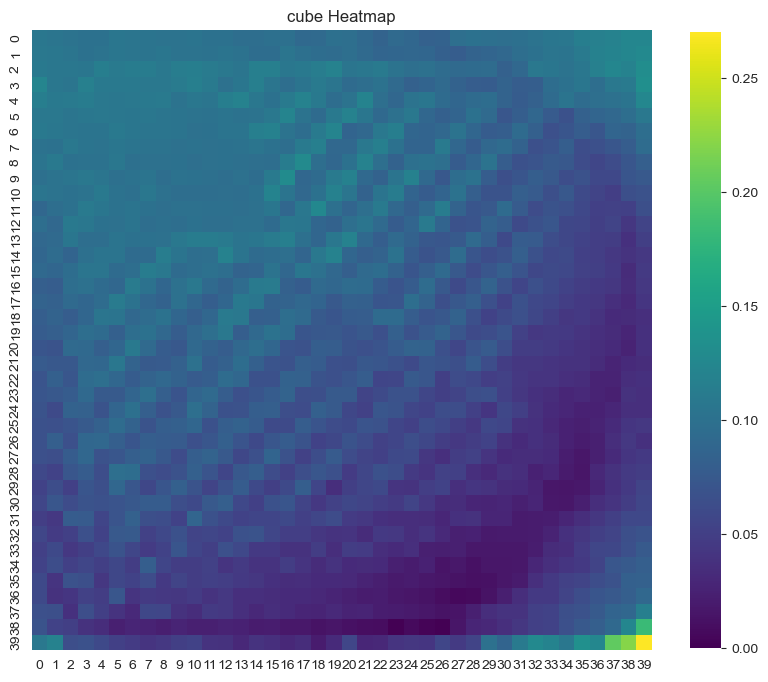

In [18]:
plot_heatmap(get_heatmap(sample_points))